In [1]:
#!pip install torch==1.9.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.9.1+cpu torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchaudio

In [142]:
#!pip install audtorch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import torch
import os
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import sklearn 

from IPython.display import clear_output
import tqdm.notebook as tqdm
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from torch import nn
from sklearn.metrics import classification_report

import torch.nn.functional as F

#import audtorch
%matplotlib inline

In [144]:
from utils.dataloader import make_sorted_dataloader, collate_with_paddings
from utils.chunk_dataset import ChunkDataSet
from utils.zip_dataset import ZippedDataSet
from utils.chunk_augmented_dataset import ChunkAugDataSet

import utils.load_data

In [145]:
!ls data/

Annotations_gold_standard-20220202T091454Z-001.zip
Data-20211102T111411Z-001.zip
Data-20211102T111411Z-002.zip
Data-20211102T111411Z-003.zip
ds_chunk2s.zip
ds_chunk400ms.zip
ds.zip
noises
NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data
NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data-20220322T103638Z-001.zip
trainds_chunk400ms_msl0.4.zip


In [146]:
s = utils.load_data.load_anno_tensor('data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train/039_2016-04-07_Nottingham/annotation_expert.txt')


In [147]:
type(s.shape[0])

int

In [148]:
int.from_bytes((s.shape[0]).to_bytes(4, byteorder='big'), 'big')

13411

In [149]:
#train_ds = 
chunk_sz=6
DATA_BASEDIR="data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English"

# train_ds = ZippedDataSet(f'{DATA_BASEDIR}/train_chunk{chunk_sz}s_msl0.zip', 
#                          ChunkDataSet(f'{DATA_BASEDIR}/train/', chunk_size_s=chunk_sz), 
#                          rewrite=True, 
#                          min_sample_len=0)
test_ds = ZippedDataSet(f'{DATA_BASEDIR}/test_chunk{chunk_sz}s_msl0.zip', 
                        ChunkDataSet(f'{DATA_BASEDIR}/test', chunk_size_s=chunk_sz), 
                        rewrite=True, 
                        min_sample_len=0)

344 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/test_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (344 -> 344)


  0%|          | 0/344 [00:00<?, ?it/s]

In [154]:
test_ds[0]['labels']

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.6667, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.6667, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.6667, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.6667, 0.0000, 0.0000],


In [151]:
4240/52

81.53846153846153

In [152]:
test_ds.feats_dim

80

In [153]:
test_ds.anno_dim

5

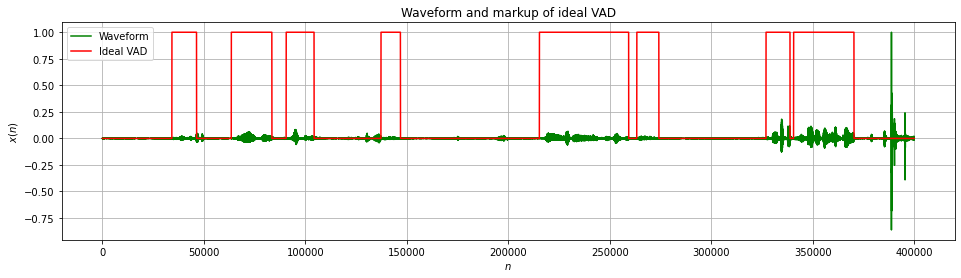

In [15]:
class ClsDatasetWrapper:
    def __init__(self, ds):
        self.ds = ds
        self.brackets_l = torch.Tensor([0,    0.45, 0.6, 0.8])
        self.brackets_r = torch.Tensor([0.45, 0.6,  0.8, 1.1])
    
    def __getitem__(self, index):
        item  = self.ds[index]
        l = item['labels'].mean() # .view(-1, 1)
        cls_labels = torch.where((self.brackets_l <= l) & (self.brackets_r > l))[0][0] # torch.nonzero((brackets_l <= l) & (brackets_r > l))[:, 1]
        #print(cls_labels)
        assert cls_labels.shape == l.shape, f'{cls_labels=} {l=}'
        item['cls_labels'] = cls_labels
        return item
    
    def __len__(self):
        return len(self.ds)

    def total_sec(self):
        return self.ds.total_sec()

    def size(self, index):
        return self.ds.size(index)
    
    def __getattr__(self, name):
        return getattr(self.ds, name)
    
train_cls_ds = ClsDatasetWrapper(train_ds)
test_cls_ds = ClsDatasetWrapper(test_ds)

In [16]:
# print(train_cls_ds[1]['feats'])
# t = torchaudio.transforms.TimeMasking(100)
# t.train()
# print(t(train_cls_ds[1]['feats']))
# t.eval()
# print(t(train_cls_ds[1]['feats']))


In [17]:
train_cls_ds[0]['feats'].shape

torch.Size([80, 46])

In [18]:
getattr(train_cls_ds.ds, 'min_sample_len', -1)

0

In [19]:

class EfficientNetASR(nn.Module):                                                                                                                                                                 
    def __init__(self, efficient_net_version='b0', num_cls=4, aug_prob=0.9):                                                                                                                                         
        super().__init__()
        assert efficient_net_version is not None
        self.aug_prob = aug_prob
        self.aug = nn.Sequential(torchaudio.transforms.TimeMasking(20), #12
                                        torchaudio.transforms.TimeMasking(20), #12
                                        torchaudio.transforms.FrequencyMasking(8),
                                        torchaudio.transforms.FrequencyMasking(8))
            
        self.efficientnet_model = EfficientNet.from_pretrained('efficientnet-%s' % efficient_net_version)                                                                                                                                                             
        self.efficientnet_model._conv_stem = Conv2dStaticSamePadding(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=(128, 188))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(1000, 256, bias=True)                                                                                                                                  
        self.head = nn.Linear(256, num_cls)
        #self.sig = torch.nn.Sigmoid()
        
    def forward(self, x):
        if self.training:
            p = random.random()
            if p <= self.aug_prob:    
                x = self.aug(x)
        else:
            x = self.aug(x)
        x = x.unsqueeze(dim=1)
        x = F.relu(self.efficientnet_model(x))
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.head(x)
        #print(x.shape)
        return x


In [20]:
def get_cls_weights(ds, num_classes=4):
    cls2num = [0]*num_classes
    for i in tqdm.tqdm(range(len(ds))):
        item = ds[i]
        cls2num[item['cls_labels']]+=1
    return torch.Tensor(cls2num)
get_cls_weights(train_cls_ds)

  0%|          | 0/6138 [00:00<?, ?it/s]

tensor([ 271., 2748., 2783.,  336.])

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp).detach()
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [22]:
def get_criterion(train_ds, criterion='ce', device='cpu', gamma=1):
    if criterion == 'ce':
        weights = get_cls_weights(train_ds) ** gamma
        return nn.CrossEntropyLoss(weight=(1/weights).to(device), ignore_index=-1)
    if criterion == 'focal':
        return FocalLoss(gamma=focal_gamma)
    

In [23]:
def eval_reg(model, dataloader, device='cpu'):
    model.eval()
    raise NotImplementedError()
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch

            logits_mean = logits.mean(dim=1)#/pad_batch.sum(dim=1)
            y_mean = y_batch.sum(dim=1)/pad_batch.sum(dim=1)
            loss = ((y_mean - logits_mean)**2).mean().cpu().item()
            losses.append(loss)
    return np.mean(losses)

def eval_cls(model, dataloader, device='cpu', calc_report=True, criterion=None):
    model.eval()
    losses = []
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
    truth = []
    predicted = [] 
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['cls_labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) 
            #print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            losses.append(loss.item())
            predicted.append(logits.argmax(dim=-1).cpu().numpy())
            truth.append(batch['cls_labels'].cpu().numpy())
    cr = None
    conf_matrix = None
    if calc_report:
        truth = np.concatenate(truth)
        predicted = np.concatenate(predicted)
        labels = [f'[{l:.2f},{r:.2f})' for l,r in zip([0,    0.45, 0.6, 0.8], [0.45, 0.6,  0.8, 1.1])]
        cr = classification_report(truth, predicted, target_names=labels)
        conf_matrix = sklearn.metrics.confusion_matrix(truth, predicted)#, labels=labels)
    return np.mean(losses), cr, conf_matrix


        
def train_per_chunk(model, train_dl, val_dl, 
                    epochs=10, 
                    device='cpu', 
                    lr=1e-3, 
                    gamma=0.95,
                    weight_decay=1e-6,
                    criterion=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
    
    train_losses = []
    val_losses = []
    last_val = float('inf')
    t1 = tqdm.tqdm(range(1, epochs+1))
    best_val_loss = float('inf')
    for e in t1:
        #print(f'Epoch {e}/{epochs}')
        #tqdm.tqdm
        losses = []
        t2 = (train_dl)
        for batch in t2:
            model.train()
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['cls_labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch         
            loss  = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

            t1.set_description(desc=f"Ep {e}, loss={losses[-1]:.5f}, val={last_val:.5f}")
            #break
        scheduler.step()
        train_losses.append(np.mean(losses))
        last_val, cr, _ = eval_cls(model, val_dl, device=device, criterion=criterion, calc_report=False)
        val_losses.append(last_val)
        if best_val_loss > last_val:
            torch.save(model, 'models/model.best.pt')
            best_val_loss = last_val
            print(f"Best val loss {last_val}")
        #print(cr)
        
    plt.figure(figsize=(8, 8)); plt.title('Train losses')
    plt.xlabel('iter') ; plt.ylabel('loss'); plt.grid()
    plt.plot(train_losses, label='train loss')
    val_losses = np.array(val_losses)
    val_losses[val_losses>2] = 2
    plt.plot(val_losses, label='test loss')
    plt.legend()
    plt.show()
    return model 

In [24]:
train_cls_ds.sizes

array([1.84, 1.92, 2.09, ..., 6.  , 6.  , 6.  ])

In [25]:
btz=128
device='cuda'
train_dl = make_sorted_dataloader(train_cls_ds, batch_size=btz, min_sample_len=0)
test_dl = make_sorted_dataloader(test_cls_ds, batch_size=btz, min_sample_len=0)


Dataloader min_sample_len=0
SortedSampler remove 0 (6138 -> 6138)
Dataloader min_sample_len=0
SortedSampler remove 0 (1825 -> 1825)


In [26]:
len(test_dl)

15

In [27]:
model = EfficientNetASR('b1').to(device)
r = eval_cls(model, test_dl, device=device, criterion=None)
print(r[0])
print(r[1])
print(r[2])

Loaded pretrained weights for efficientnet-b1
1.7364544550577798
              precision    recall  f1-score   support

 [0.00,0.45)       0.06      0.88      0.12       107
 [0.45,0.60)       0.47      0.13      0.21       745
 [0.60,0.80)       0.59      0.06      0.12       970
 [0.80,1.10)       0.00      0.00      0.00         3

    accuracy                           0.14      1825
   macro avg       0.28      0.27      0.11      1825
weighted avg       0.51      0.14      0.15      1825

[[ 94   8   2   3]
 [592 100  41  12]
 [789 107  62  12]
 [  3   0   0   0]]


  0%|          | 0/6138 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b1


  0%|          | 0/100 [00:00<?, ?it/s]

Best val loss 1.2220377504825592
Best val loss 1.1296109358469646


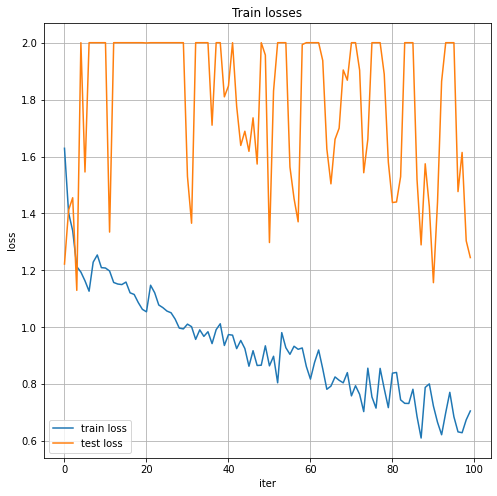

In [28]:
criterion = get_criterion(train_cls_ds, 'ce', device, gamma=1.4)
model = EfficientNetASR('b1').to(device)
#model = CNN_blstm().to(device)
model = train_per_chunk(model, 
                        train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=100, 
                        lr=1e-4,
                        weight_decay=1e-4, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)
torch.save(model, 'models/it2/effnet.tmp.pt')
# train= val=0.01172. btz=40, epochs=60, lr=1e-4
# train= val=0.01155. btz=128, epochs=60, lr=1e-4
# train= val=. btz=128, epochs=60, lr=1e-3
# train= val=. btz=128, epochs=60, lr=1e-5
# mse^2 train= val=0.01417. btz=128, epochs=60, lr=1e-3


In [113]:
# criterion = get_criterion(train_cls_ds, 'focal', device)
# model = EfficientNetASR('b1').to(device)
# #model = CNN_blstm().to(device)
# model = train_per_chunk(model, 
#                         train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
#                         epochs=200, 
#                         lr=1e-4,
#                         weight_decay=1e-6, 
#                         gamma=1,
#                         device=device, 
#                         criterion=criterion)
# torch.save(model, 'models/it2/effnet.focal.pt')

In [114]:
#model = torch.load('models/it2/effnet.chunk.4c.pt')

In [115]:
# losses = []
# for lr in [1e-3, 1e-4, 2e-4]:
#     for g in [1, 0.95, 0.9]:
#         for w in [1e-6, 0, 1e-2]:
#             print(f'Parameters {lr=} {g=} {w=}')
#             model = EfficientNetASR('b1').to(device)
#             #model = CNN_blstm().to(device)
#             model = train_per_chunk(model, 
#                                     train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
#                                     epochs=100, 
#                                     lr=lr,
#                                     weight_decay=w, 
#                                     gamma=g,
#                                     device=device, 
#                                     criterion=criterion)
#             loss_train, cr = eval_cls(model, train_dl, device=device)
#             print(f'{loss=}')
#             print(cr)
#             loss, cr = eval_cls(model, test_dl, device=device)
#             print(f'{loss=}')
#             print(cr)
#             losses.append((lr, g, w, loss_train, loss))
# losses

In [32]:
model = torch.load('models/it2/effnet.tmp.pt')

loss, cr, conf = eval_cls(model, test_dl, device=device)
print(f'{loss=}')
print(cr)
print(conf)

loss=1.2420459151268006
              precision    recall  f1-score   support

 [0.00,0.45)       0.17      0.64      0.27       107
 [0.45,0.60)       0.54      0.33      0.41       745
 [0.60,0.80)       0.70      0.66      0.68       970
 [0.80,1.10)       0.00      0.00      0.00         3

    accuracy                           0.52      1825
   macro avg       0.35      0.41      0.34      1825
weighted avg       0.60      0.52      0.54      1825

[[ 69  20  18   0]
 [239 246 255   5]
 [ 93 185 640  52]
 [  0   2   1   0]]


In [31]:

model = torch.load('models/model.best.pt')
loss, cr, conf = eval_cls(model, test_dl, device=device)
print(f'{loss=}')
print(cr)
print(conf)
# 0.013951944429427385

loss=1.6760759830474854
              precision    recall  f1-score   support

 [0.00,0.45)       0.06      1.00      0.12       107
 [0.45,0.60)       0.20      0.02      0.04       745
 [0.60,0.80)       0.92      0.03      0.07       970
 [0.80,1.10)       0.00      0.00      0.00         3

    accuracy                           0.09      1825
   macro avg       0.29      0.26      0.06      1825
weighted avg       0.57      0.09      0.06      1825

[[107   0   0   0]
 [726  16   3   0]
 [873  64  33   0]
 [  3   0   0   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [ ]:
!cp 

In [ ]:
def brackets_acccuracy(model, dl, device='cpu'):
    #, n=4
    #brackets_l = np.linspace(0, 1.01, n+1)[:-1]
   
    #brackets_r = np.linspace(0, 1.01, n+1)[1:]
    brackets_l = np.array([0,    0.45, 0.6, 0.8])
    brackets_r = np.array([0.45, 0.6,  0.8, 1.1])
    
    predicted=[]
    truth=[]
    with torch.no_grad():
        for batch in dl:
            x = batch['feats'].to(device) 
            p = batch['padding']
            labels = batch['labels'].sum(dim=1)/p.sum(dim=1)
            labels = labels.view(-1).numpy() 
            
            logits = model(x).cpu().view(-1).numpy()
            assert labels.shape == logits.shape, f' {labels.shape=} {logits.shape=}'
            for l, y in zip(logits, labels):
                pos_l = np.where((brackets_l <= l) * (brackets_r > l))[0]
                pos_y = np.where((brackets_l <= y) * (brackets_r > y))[0]
                assert pos_l.shape == pos_y.shape == (1,), f'{pos_l=} {pos_y=}, {brackets_l=}, {brackets_r=}, {l=}, {y=}'
                predicted.append(pos_l[0])
                truth.append(pos_y[0])
    #print([(y,p) for y,p in zip(truth, predicted)])
    print(classification_report(truth, predicted, target_names=[f'[{l:.2f},{r:.2f})' for l,r in zip(brackets_l, brackets_r)]))
    
brackets_acccuracy(model, val_dl, device=device)

In [ ]:
n=10
brackets_l = np.linspace(0, 1.01, n+1)[:-1]
brackets_r = np.linspace(0, 1.01, n+1)[1:]
bins = np.zeros(n)
logits = np.array([0.01, 0.002, 0, 0.11, 0.99, 0.55, 1.])
for l in logits:
    pos = (brackets_l <= l) * (brackets_r > l)
    print(l, pos)
    print(np.where(pos)[0])
    #bins[pos]+=1
#print(bins)

In [ ]:
def predict(self, dl, device='cpu'):
    #feats - feats_dim X seq_len
    predicts = []
    labels = []
    padds = []
    # #torch.utils.data.DataLoader(ds, 
    #                                            collate_fn=collate,
    #                                            sampler=SortedSampler(ds), 
    #                                            shuffle=False, 
    #                                            batch_size=64):
    with torch.no_grad():
        for batch in dl: 
            x = batch['feats'].to(device) 
            y = batch['labels'] 
            p = batch['padding']
            logits = model(x).cpu()
            predicts.append(logits.cpu())
            labels.append(y.cpu())
            padds.append(p.cpu())
    return predicts, labels, padds

#ds = FolderDataSet('/content/drive/MyDrive/учебка/магистратура/ULM/Data/',  novices=False) # egs_list=['030_2016-04-06_Nottingham'],

plp = predict(model, val_dl, device=device)      

In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :].mean() #[one_pads==1].mean()
        one_label = l_batch[i, :][one_pads==1]
        l_mean = one_label.mean()
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_label))
        plt.figure(figsize=(5,5))
        #plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.scatter(1, one_predict)
        plt.scatter(2, l_mean)
        plt.legend(['real', 'predict_mean', 'real_mean'])
        plt.show()
        if i >=10:
            break
    break

In [ ]:
l_mean=[]
predicted_mean=[]
for p_batch, l_batch, pad_batch in zip(*plp):
    predicted_mean.append(p_batch.view(-1)) #.sum(dim=1)/pad_batch.sum(dim=1)
    #one_label = l_batch[i, :][one_pads==1]
    l_mean.append(l_batch.sum(dim=1)/pad_batch.sum(dim=1))
    #deltas
    # one_predict = one_predict[:-1]
    # one_label = one_label[1:] - one_label[:-1]
    #
predicted_mean = torch.cat(predicted_mean)
l_mean = torch.cat(l_mean)
x = np.arange(len(l_mean))
plt.figure(figsize=(25,5))
#plt.plot(x, one_predict)
#plt.plot(x, one_label)
plt.plot(x,  l_mean, '^')
plt.plot(x, predicted_mean, 'x')
#plt.scatter(1, one_predict)
#plt.scatter(2, l_mean)
plt.legend(['real_mean', 'predict_mean'])
plt.show()


In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        # one_predict = one_predict[:-1]
        # one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=3:
            break

In [ ]:
for p_batch, l_batch, pad_batch in zip(*plp):
    for i in range(p_batch.shape[0]):
        one_pads = pad_batch[i, :]
        one_predict = p_batch[i, :][one_pads==1]
        one_label = l_batch[i, :][one_pads==1]
        #deltas
        one_predict[0] = one_label[0]
        for j in range(1, len(one_predict)):
            one_predict[j] += one_predict[j-1]
        #one_label = one_label[1:] - one_label[:-1]
        #
        x = np.arange(len(one_predict))
        plt.figure(figsize=(5,5))
        plt.title("Delta predict. Ground truth first step")
        plt.plot(x, one_predict)
        plt.plot(x, one_label)
        plt.legend(['predicted', 'real'])
        plt.show()
        if i >=10:
            break

In [ ]:
#for idx in random_idxes:
ipd.display(ipd.Audio(item['expert_wav'][0, :25*chk_len*16], rate=16000))